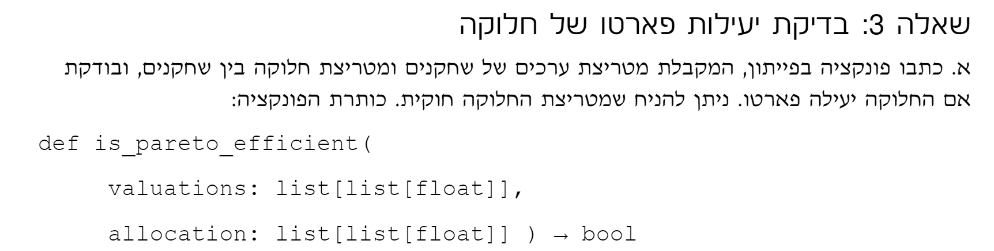
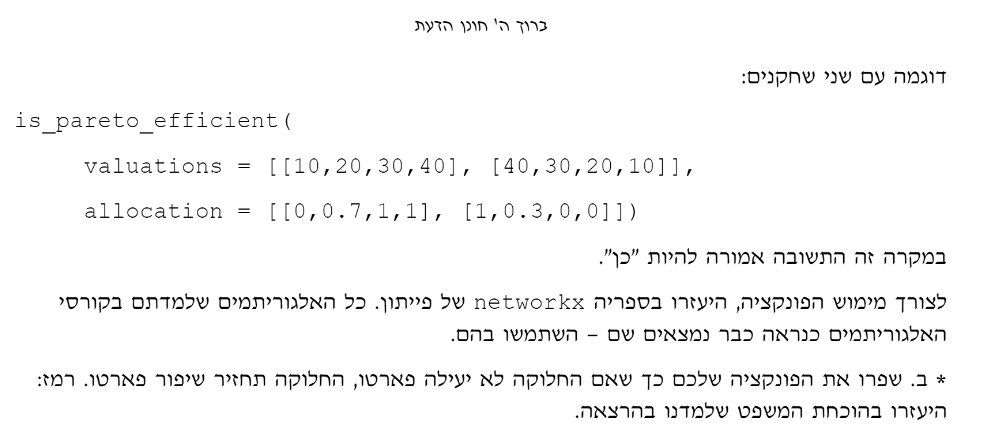

In [24]:
import networkx as nx
import math
from typing import List

def build_graph(valuations: List[List[float]], allocations: List[List[float]]) -> nx.DiGraph:
    """
    Build a directed graph representing the allocation scenario.

    Args:
    - valuations (List[List[float]]): The valuation matrix where valuations[i][j] represents the value of item j for player i.
    - allocations (List[List[float]]): The allocation matrix where allocations[i][j] represents the amount of item j allocated to player i.

    Returns:
    - nx.DiGraph: Directed graph representing the allocation scenario.
    """
    num_players = len(valuations)
    nx_graph = nx.DiGraph()

    # Iterate over all pairs of players to calculate the weights of edges between them
    for i in range(num_players):
        for j in range(num_players):
            if i != j:
                # Calculate the minimum weight edge between Player_i and Player_j
                # based on their valuation and allocation of items
                min_weight, index = min(
                    (
                        (math.log(valuations[i][z] / valuations[j][z]), z)
                        for z, allocation in enumerate(allocations[i])
                        if allocation > 0
                    ),
                    default=(float('inf'), -1)
                )
                # Add an edge between Player_i and Player_j with weight min_weight
                # and item index as an attribute
                nx_graph.add_edge(f"Player_{i}", f"Player_{j}", weight=min_weight, item=index)

    return nx_graph

def is_pareto_efficient(valuations: List[List[float]], allocations: List[List[float]]) -> bool:
    """
    Check if a given allocation is Pareto efficient.

    Args:
    - valuations (List[List[float]]): The valuation matrix where valuations[i][j] represents the value of item j for player i.
    - allocations (List[List[float]]): The allocation matrix where allocations[i][j] represents the amount of item j allocated to player i.

    Returns:
    - bool: True if the allocation is Pareto efficient, False otherwise.
    """
    nx_graph = build_graph(valuations, allocations)

    # Check for negative weight cycles using NetworkX's Bellman-Ford algorithm
    negative_cycle = nx.negative_edge_cycle(nx_graph, weight='weight')

    return not negative_cycle  # If no negative weight cycle, return True



In [25]:

def test_is_pareto_efficient():
    valuations1 = [[10, 20, 30, 40], [40, 30, 20, 10]]
    allocations1 = [[0, 0.7, 1, 1], [1, 0.3, 0, 0]]
    assert is_pareto_efficient(valuations1, allocations1) == True

    valuations2 = [[3, 1, 6], [6, 3, 1], [1, 6, 3]]
    allocations2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    assert is_pareto_efficient(valuations2, allocations2) == False
    
    valuations3 = [[3, 1, 6], [6, 3, 1], [1, 6, 3]]
    allocations3 = [[0, 0, 1], [1, 0, 0], [0, 1, 0]]
    assert is_pareto_efficient(valuations3, allocations3) == True

if __name__ == "__main__":
    test_is_pareto_efficient()
    print("All tests passed!")


All tests passed!


# PART B

In [47]:
def find_positive_allocation_resources(player_alloc: List[float], threshold: float) -> List[int]:
    """
    Find resources with allocations greater than or equal to the given threshold.

    Args:
    - player_alloc (List[float]): Allocation of resources for a player.
    - threshold (float): Threshold for positive allocation.

    Returns:
    - List[int]: Indices of resources with positive allocations.

    """
    return [idx for idx, alloc in enumerate(player_alloc) if alloc >= threshold]


def transfer_resources(alloc_matrix: List[List[float]], source_player: int, resource_idx: int, amount: float,
                       destination_player: int) -> None:
    """
    Transfer resources between players.

    Args:
    - alloc_matrix (List[List[float]]): Current allocation matrix.
    - source_player (int): Index of the player transferring resources.
    - resource_idx (int): Index of the resource being transferred.
    - amount (float): Amount of resources to transfer.
    - destination_player (int): Index of the player receiving the transferred resources.

    """
    alloc_matrix[source_player][resource_idx] -= amount
    alloc_matrix[destination_player][resource_idx] += amount


def improve_pareto(valuations: List[List[float]], current_allocation: List[List[float]]) -> List[List[float]]:
    """
    Improve a given allocation to achieve Pareto efficiency.

    Args:
    - valuations (List[List[float]]): List of valuations for each player.
    - current_allocation (List[List[float]]): Current allocation matrix.

    Returns:
    - List[List[float]]: Improved Pareto efficient allocation.
    
     Examples:
    >>> improve_pareto([[5, 10, 15], [15, 5, 10]], [[0.2, 1, 0], [0.8, 0, 1]])
    [[0.0, 1, 0.2], [1.0, 0, 0.8]]

    >>> improve_pareto([[10, 20, 30, 40], [40, 30, 20, 10]], [[0, 0.7, 1, 1], [1, 0.3, 0, 0]])
    [[0, 0.7, 1, 1], [1, 0.3, 0, 0]]

    >>>improve_pareto([[10, 20, 30, 40], [40, 30, 20, 10]], [[0, 0.5, 1, 1], [1, 0.5, 0, 0]])
    [[0, 0.5, 1, 1], [1, 0.5, 0, 0]]

    >>> improve_pareto([[3, 6, 1], [6, 1, 3], [1, 3, 6]], [[0, 1, 0], [1, 0, 0], [0, 0, 1]])
    [[0, 1, 0], [1, 0, 0], [0, 0, 1]]

   
    """
    
    num_players = len(valuations)
    improved_allocation = [row.copy() for row in current_allocation]
    epsilon = 0.1  # Threshold for positive allocation

    while not is_pareto_efficient(valuations, improved_allocation):
        for i in range(num_players):
            positive_resources = find_positive_allocation_resources(improved_allocation[i], epsilon)

            if positive_resources:
                min_val_resource = min(positive_resources, key=lambda res_idx: valuations[i][res_idx])
                transfer_amount = min(epsilon, improved_allocation[i][min_val_resource])

                transfer_resources(improved_allocation, i, min_val_resource, transfer_amount, (i + 1) % num_players)

    return improved_allocation


In [51]:
improve_pareto([[5, 10, 15], [15, 5, 10]], [[0.2, 1, 0], [0.8, 0, 1]])

[[0.0, 1, 0.2], [1.0, 0, 0.8]]

In [48]:
improve_pareto([[10, 20, 30, 40], [40, 30, 20, 10]], [[0, 0.7, 1, 1], [1, 0.3, 0, 0]])

[[0, 0.7, 1, 1], [1, 0.3, 0, 0]]

In [49]:
improve_pareto([[10, 20, 30, 40], [40, 30, 20, 10]], [[0, 0.5, 1, 1], [1, 0.5, 0, 0]])

[[0, 0.5, 1, 1], [1, 0.5, 0, 0]]

In [50]:
improve_pareto([[3, 6, 1], [6, 1, 3], [1, 3, 6]], [[0, 1, 0], [1, 0, 0], [0, 0, 1]])

[[0, 1, 0], [1, 0, 0], [0, 0, 1]]